# Exploration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Input

In [2]:
from sklearn.datasets import load_files

raw_corpus = load_files("../data/")

In [3]:
doc_count = len(raw_corpus.data)
print("Doc count:", doc_count)
assert doc_count is 60, "Wrong number of documents loaded, should be 60 (4 novels + 56 stories)"

Doc count: 60


In [4]:
print("Beginning:\n", raw_corpus.data[0][:500], "\n")
print("End:\n", raw_corpus.data[0][-200:])

Beginning:
 b'\n\n\n\n                              THE ADVENTURE OF THE\n                                          \n                                MISSING THREE-QUARTER\n\n                               Arthur Conan Doyle\n\n\n\n     We were fairly accustomed to receive weird telegrams at Baker Street,\n     but I have a particular recollection of one which reached us on a\n     gloomy February morning some seven or eight years ago and gave Mr.\n     Sherlock Holmes a puzzled quarter of an hour. It was addressed to\n     ' 

End:
 b'your discretion and that of your friend."\n\n     Holmes grasped the doctor\'s hand.\n\n     "Come, Watson," said he, and we passed from that house of grief into\n     the pale sunlight of the winter day.\n\n'


## Baseline

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents="ascii", lowercase=True)
X = tfidf.fit_transform(raw_corpus.data)

In [6]:
print(len(tfidf.get_feature_names()))
X.shape

19099


(60, 19099)

In [7]:
#tfidf.get_feature_names()

## Preparation

In [8]:
# Wrangler
import re, unicodedata

from sklearn.feature_extraction import stop_words
from nltk import wordpunct_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download(["punkt", "wordnet"], download_dir="../nltk/")
nltk.data.path.append("../nltk/")

class TextWrangler(object):
    """ Clean and tokenize documents.

    Tokenize documents. Removes punctuation and stopwords.
    Converts tokens to lowercase. Replaces numbers with generic number token.
    Depending on `kind` paramter, stems or lemmatizes tokens.

    Parameters
    ----------
    kind : str
        Either "stem" (default) for stemming or "lemma" for lemmatization

    """
    def __init__(self, kind="stem"):
        self.kind = kind
        self.stemmer = LancasterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        sklearn_stopwords = stop_words.ENGLISH_STOP_WORDS
        custom_stopwords = ["arthur", "conan", "doyle", "chapter", "contents", '`--"', "`"]
        self.stopwords = sklearn_stopwords.union(custom_stopwords)

    def __call__(self, document):
        if self.kind == "lemma":
            tokens = [self.lemmatizer.lemmatize(token.lower())
                      for token in wordpunct_tokenize(document)
                      if not self.is_punct(token)
                      and not self.is_singlechar(token)
                      and not self.is_stopword(token.lower())]
        else:
            tokens = [self.stemmer.stem(token.lower())
                      for token in wordpunct_tokenize(document)
                      if not self.is_punct(token)
                      and not self.is_singlechar(token)
                      and not self.is_stopword(token.lower())]

        clean_tokens = ["NUM" if self.is_number(token) else token
                        for token in tokens]

        return clean_tokens

    def is_punct(self, token):
        return all(unicodedata.category(char).startswith("P") for char in token)
    
    def is_singlechar(self, token):
        return len(token) < 2
    
    def is_stopword(self, token):
        return token in self.stopwords
    
    def is_number(self, token):
        return bool(re.match(r"\d+", token))


[nltk_data] Downloading package punkt to ../nltk/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to ../nltk/...
[nltk_data]   Package wordnet is already up-to-date!


## Vectorizer

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_pure = CountVectorizer(strip_accents="ascii", lowercase=True, stop_words=None)
X_bow_pure = bow_pure.fit_transform(raw_corpus.data)

bow_stem = CountVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="stem"))
X_bow_stem = bow_stem.fit_transform(raw_corpus.data)

tfidf_stem = TfidfVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="stem"))
X_tfidf_stem = tfidf_stem.fit_transform(raw_corpus.data)

bow_lemma = CountVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="lemma"))
X_bow_lemma = bow_lemma.fit_transform(raw_corpus.data)

tfidf_lemma = TfidfVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="lemma"))
X_tfidf_lemma = tfidf_lemma.fit_transform(raw_corpus.data)

In [10]:
print("Pure bow vector:", X_bow_pure.shape)
print(bow_pure.get_feature_names()[:10], "...")
print("Stemmed bow vector:", X_bow_stem.shape)
print(bow_stem.get_feature_names()[:10], "...")
print("Lemmatized bow vector:", X_bow_lemma.shape)
print(bow_lemma.get_feature_names()[:10], "...")
print("Stemmed tfidf vector:", X_tfidf_stem.shape)
print(tfidf_stem.get_feature_names()[:10], "...")
print("Lemmatized tfidf vector:", X_tfidf_lemma.shape)
print(tfidf_lemma.get_feature_names()[:10], "...")

Pure bow vector: (60, 19099)
['000', '10', '100', '1000', '104', '109', '10s', '10th', '11', '1100'] ...
Stemmed bow vector: (60, 9710)
['NUM', 'ab', 'aback', 'abandon', 'abash', 'abba', 'abbess', 'abbey', 'abbot', 'abduc'] ...
Lemmatized bow vector: (60, 16474)
['NUM', 'aback', 'abandon', 'abandoned', 'abandoning', 'abashed', 'abated', 'abbas', 'abbess', 'abbey'] ...
Stemmed tfidf vector: (60, 9710)
['NUM', 'ab', 'aback', 'abandon', 'abash', 'abba', 'abbess', 'abbey', 'abbot', 'abduc'] ...
Lemmatized tfidf vector: (60, 16474)
['NUM', 'aback', 'abandon', 'abandoned', 'abandoning', 'abashed', 'abated', 'abbas', 'abbess', 'abbey'] ...


# Vectors

## Ranking

In [11]:
# Ranking word patterns
def rank(features, values, metric):
    data = []
    for col, term in enumerate(features):
        data.append((term, values[0, col]))

    df = pd.DataFrame(data, columns=["term", metric])
    order = df.sort_values(metric, ascending=False)
    order.reset_index(drop=True, inplace=True)
    order.index = order.index + 1
    return order

In [12]:
assert bow_stem.get_feature_names() == tfidf_stem.get_feature_names(), "Mismatch of stem feature names (->tokenize)"
assert bow_lemma.get_feature_names() == tfidf_lemma.get_feature_names(), "Mismatch of lemma feature names (->tokenize)"
stem_features = bow_stem.get_feature_names()
lemma_features = bow_lemma.get_feature_names()
pure_features = bow_pure.get_feature_names()

bow_stem_sum = X_bow_stem.sum(axis=0)
bow_lemma_sum = X_bow_lemma.sum(axis=0)
bow_pure_sum = X_bow_pure.sum(axis=0)

tfidf_stem_mean = X_tfidf_stem.mean(axis=0)
tfidf_lemma_mean = X_tfidf_lemma.mean(axis=0)

In [13]:
bow_stem_ranked = rank(stem_features, bow_stem_sum, "bow_sum") 
bow_lemma_ranked = rank(lemma_features, bow_lemma_sum, "bow_sum")
bow_pure_ranked = rank(pure_features, bow_pure_sum, "bow_sum")

print("BOW Pure:\n", bow_pure_ranked.head(15), "\n")
print("BOW Stem:\n", bow_stem_ranked.head(15), "\n")
print("BOW Lemma:\n", bow_lemma_ranked.head(15))

BOW Pure:
     term  bow_sum
1    the    36077
2    and    17553
3     of    16676
4     to    16007
5   that    11471
6     it    11085
7     in    10734
8     he    10354
9    was     9830
10   you     9654
11   his     7822
12    is     6640
13   had     6046
14  have     5515
15    my     5275 

BOW Stem:
       term  bow_sum
1     said     3103
2     holm     3040
3      man     2636
4       mr     1737
5      com     1436
6     hand     1300
7     know     1213
8     room     1144
9     look     1114
10     tim     1106
11     fac     1055
12  watson     1036
13   littl     1033
14     sir     1024
15     did     1007 

BOW Lemma:
       term  bow_sum
1     said     3103
2   holmes     3040
3      man     2296
4       mr     2043
5     come     1197
6     hand     1180
7     know     1159
8     room     1139
9     time     1102
10  watson     1036
11  little     1033
12     sir     1024
13     did     1007
14    face      958
15   house      955


In [14]:
tfidf_stem_ranked = rank(stem_features, tfidf_stem_mean, "tfidf_mean") 
tfidf_lemma_ranked = rank(lemma_features, tfidf_lemma_mean, "tfidf_mean")

print("TFIDF Stem:\n", tfidf_stem_ranked.head(15), "\n")
print("TFIDF Lemma:\n", tfidf_lemma_ranked.head(15))

TFIDF Stem:
       term  tfidf_mean
1     holm    0.170294
2     said    0.153850
3      man    0.126640
4       mr    0.094653
5      com    0.070754
6     hand    0.065268
7     room    0.064178
8     know    0.060830
9   watson    0.060274
10    look    0.055808
11   littl    0.054434
12     tim    0.054196
13     fac    0.053037
14     did    0.050616
15   think    0.050056 

TFIDF Lemma:
       term  tfidf_mean
1   holmes    0.164990
2     said    0.149567
3      man    0.108031
4       mr    0.106291
5     room    0.062115
6   watson    0.058467
7     come    0.057773
8     hand    0.057305
9     know    0.056255
10  little    0.053028
11    time    0.052442
12     did    0.049292
13   house    0.047723
14    face    0.047482
15   think    0.045839


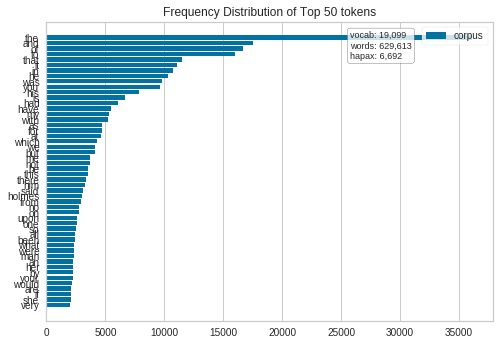

In [15]:
from yellowbrick.text.freqdist import FreqDistVisualizer

visualizer = FreqDistVisualizer(features=pure_features)
visualizer.fit(X_bow_pure)
visualizer.poof()

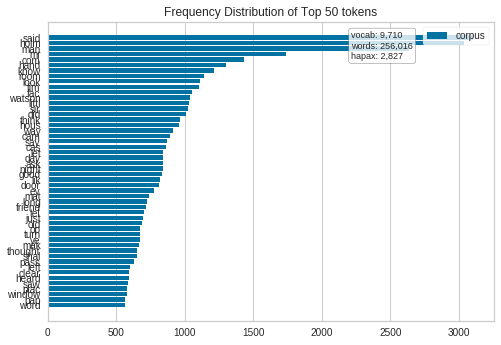

In [16]:
visualizer = FreqDistVisualizer(features=stem_features)
visualizer.fit(X_bow_stem)
visualizer.poof()

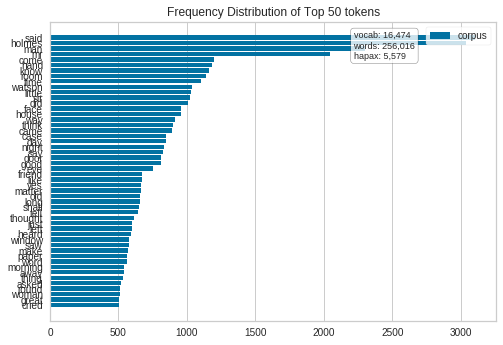

In [17]:
visualizer = FreqDistVisualizer(features=lemma_features)
visualizer.fit(X_bow_lemma)
visualizer.poof()

## Distribution

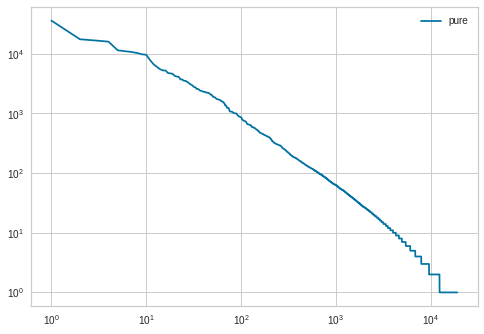

In [18]:
p_df = bow_pure_ranked
p_df.columns = [_, "pure"]

p_df.plot(loglog=True)

Stemming vs Lemma

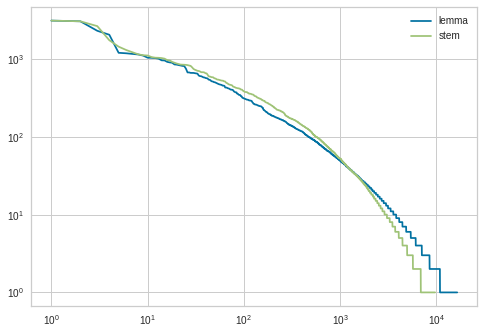

In [19]:
p_df1 = bow_lemma_ranked
p_df1.columns = [_, "lemma"]
p_df2 = bow_stem_ranked
p_df2.columns = [_, "stem"]

ax = p_df1.plot(loglog=True)
p_df2.plot(loglog=True, ax=ax)

## t-SNE

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Stemming


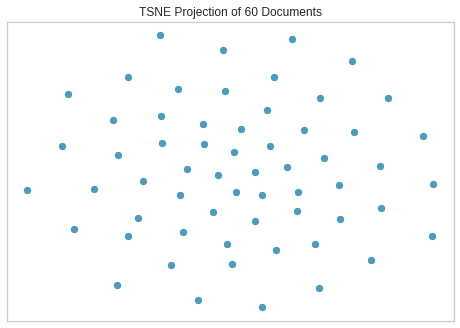

In [20]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(X_tfidf_stem)
print("Stemming")
tsne.poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Lemma


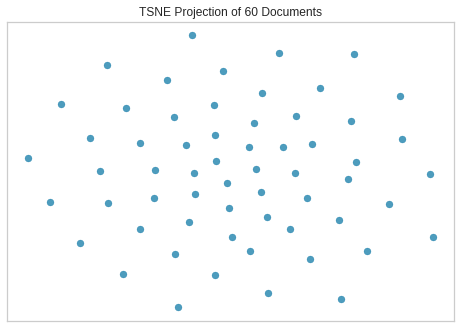

In [21]:
tsne = TSNEVisualizer()
tsne.fit(X_tfidf_lemma)
print("Lemma")
tsne.poof()

Novels [0] vs Stories [1]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


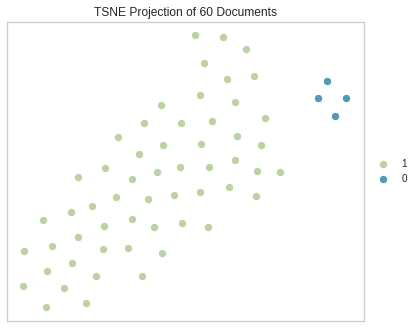

In [22]:
tsne = TSNEVisualizer()
tsne.fit(X_bow_pure, raw_corpus.target)
tsne.poof()